In [1]:
%matplotlib inline
from icecube import dataclasses, dataio, icetray
import os
import numpy as np
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

In [2]:
#######config
input_shape = [20,20,50]

In [3]:
print int(math.floor(2.2))

2


In [4]:
def make_grid_dict(input_shape, geometry):
    """Put the Icecube Geometry in a cubic grid. For each DOM calculate the grid position

    Arguments:
    input_shape : The shape of the grid (x,y,z)
    geometry : Geometry file containing the positions of the DOMs in the Detector
    """
    
    grid = dict()
    DOM_List = geometry.keys()
    xpos=[geo[i].position.x for i in DOM_List]
    ypos=[geo[i].position.y for i in DOM_List]
    zpos=[geo[i].position.z for i in DOM_List]
    xmin, xmax = np.min(xpos), np.max(xpos)
    delta_x = (xmax - xmin)/input_shape[0]
    ymin, ymax = np.min(ypos), np.max(ypos)
    delta_y = (ymax - ymin)/input_shape[1]
    zmin, zmax = np.min(zpos), np.max(zpos)
    delta_z = (zmax - zmin)/input_shape[2]
    dom_list_ret = []
    for i, odom in enumerate(DOM_List):
        dom_list_ret.append((odom.string, odom.om))
        grid[(odom.string, odom.om)] = (int(math.floor((xpos[i]-xmin)/delta_x)),
                      int(math.floor((ypos[i]-ymin)/delta_y)),
                      int(math.floor((zpos[i]-zmin)/delta_z))
                      )
    return grid, dom_list_ret


In [5]:
folderpath = '/data/ana/PointSource/PS/IC86_2012/files/sim/2012/neutrino-generator/11069/00000-00999/'
#folderpath = '../ba_code/data/'
filelist = [ f_name for f_name in os.listdir(folderpath) if f_name[-6:]=='i3.bz2']

In [6]:
print len(filelist)

980


In [6]:

DOM_List_Expanded = list(itertools.product(range(1, 87),range(1,65)))
charge_arr = []
time_arr = []
trueval_arr = []
geometry_file='/data/sim/sim-new/downloads/GCD/GeoCalibDetectorStatus_2012.56063_V0.i3.gz'
#geometry_file='../ba_code/data/GeoCalibDetectorStatus_2012.56063_V0.i3.gz'
geometry = dataio.I3File(geometry_file)
geo = geometry.pop_frame()['I3Geometry'].omgeo
DOM_List = geo.keys() ## Currently unused

In [7]:
# j=0
# for counter, in_file in enumerate(filelist):
#     if counter>10:
#         break
#     event_file = dataio.I3File(os.path.join(folderpath, in_file))
#     while event_file.more():
#             charge_arr.append(np.zeros((86,64)))
#             time_arr.append(np.full((86,64), np.inf))
#             physics_event = event_file.pop_physics()
#             pulses = physics_event['InIceDSTPulses'].apply(physics_event)
#             final_dict = dict()
#             for omkey in pulses.keys():
#                     temp_time = []
#                     temp_charge = []
#                     t_zero = np.inf
#                     for pulse in pulses[omkey]:
#                         temp_time.append(pulse.time)
#                         temp_charge.append(pulse.charge)
#                     final_dict[(omkey.string, omkey.om)] = (np.mean(temp_charge) ,np.mean(temp_time))
#                     if np.mean(temp_time)<t_zero:
#                         t_zero = np.mean(temp_time)
#             for dom in DOM_List_Expanded:
#                 if  dom in final_dict:
#                     charge_arr[j][dom[0]-1][dom[1]-1] = final_dict[dom][0]
#                     time_arr[j][dom[0]-1][dom[1]-1] = final_dict[dom][1]
#                 else:
#                     charge_arr[j][dom[0]-1][dom[1]-1] = 0
#                     time_arr[j][dom[0]-1][dom[1]-1] = np.inf
#             energy = physics_event['MCMostEnergeticTrack'].energy
#             azmiuth = physics_event['MCMostEnergeticTrack'].dir.azimuth 
#             zenith = physics_event['MCMostEnergeticTrack'].dir.zenith
#             trueval_arr.append([energy,azmiuth, zenith])
#             j+=1

In [ ]:
######### New Version ##########
grid, DOM_list = make_grid_dict(input_shape,geo)
j=0
charge_arr = []
time_arr = []
trueval_arr = []
for counter, in_file in enumerate(filelist):
    print counter
    event_file = dataio.I3File(os.path.join(folderpath, in_file))
    while event_file.more():
            ######### The +1 is not optimel....probably reconsider 
            charge_arr.append(np.zeros((input_shape[0]+1,input_shape[1]+1,input_shape[2]+1)))
            time_arr.append(np.full((input_shape[0]+1,input_shape[1]+1,input_shape[2]+1), np.inf))
            ###############################################
            physics_event = event_file.pop_physics()
            pulses = physics_event['InIceDSTPulses'].apply(physics_event)
            final_dict = dict()
            for omkey in pulses.keys():
                    temp_time = []
                    temp_charge = []
                    t_zero = np.inf
                    for pulse in pulses[omkey]:
                        temp_time.append(pulse.time)
                        temp_charge.append(pulse.charge)
                    final_dict[(omkey.string, omkey.om)] = (np.mean(temp_charge) ,np.mean(temp_time))
                    if np.mean(temp_time)<t_zero:
                        t_zero = np.mean(temp_time)
            for dom in DOM_list:
                grid_pos = grid[dom]
                if  dom in final_dict:
                    charge_arr[j][grid_pos[0]][grid_pos[1]][grid_pos[2]] += final_dict[dom][0]
                    time_arr[j][grid_pos[0]][grid_pos[1]][grid_pos[2]] += final_dict[dom][1]
            energy = physics_event['MCMostEnergeticTrack'].energy
            azmiuth = physics_event['MCMostEnergeticTrack'].dir.azimuth 
            zenith = physics_event['MCMostEnergeticTrack'].dir.zenith
            trueval_arr.append([energy,azmiuth, zenith])
            j+=1

0
1
2

In [ ]:
print np.shape(charge_arr)

In [ ]:
print np.shape(charge_arr[0])

In [45]:
import matplotlib as mpl

np.save('./Plots/plot_3d_event.npy',
        [np.array(list(itertools.product(np.arange(input_shape[0]+1),
                                         np.arange(input_shape[1]+1),np.arange(input_shape[2]+1))))
        ,charge_arr[45]])

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(range(input_shape[0]),
#             range(input_shape[1]),
#             range(input_shape[2]),
#             s=np.concatenate(np.concatenate(charge_arr[0])))
# plt.show()

In [50]:
np.save('truevals.npy', np.array(trueval_arr))
np.save('time.npy', np.array(time_arr))
np.save('charge.npy', np.array(charge_arr))

-----------------
hier wird versucht in jedem "stockwerk" (i.e. om-number) die zeit der zu mitteln und dann gemittelte zeit ueber stockwerknummer zu plotten

In [29]:
"""
create a two lists mapping om (i.e. height of DOM) to average time of pulses. if time is inf on every dom of this layer, dont include it into the list

tuple of these lists per frame is stored in time_per_layer
"""
time_per_layer = np.full((len(time_arr)),None)
for i, frame in enumerate(time_arr):
    om_dic = {}
    for string, stringlist in enumerate(frame):
        string += 1
        for om, domtime in enumerate(stringlist):
            om += 1
            if not np.isinf(domtime):
                if om in om_dic:
                    om_dic[om] = np.append(om_dic[om], domtime)
                else:
                    om_dic[om] = np.array([domtime])
    time_per_layer[i] = zip(*[(om, times.mean()) for om, times in om_dic.items()]) if len(om_dic) > 0 else [(),()]

frame: 0


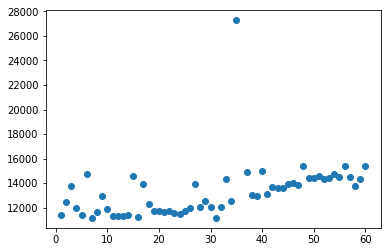

frame: 1


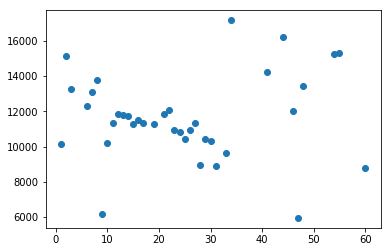

frame: 2


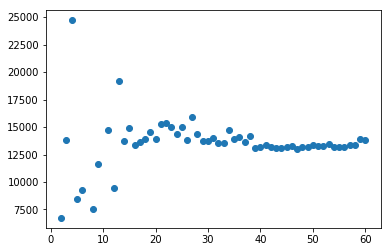

frame: 3


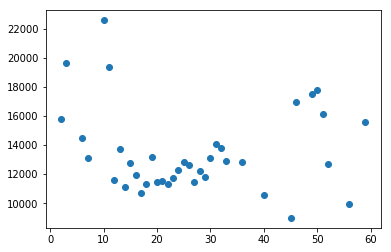

frame: 4


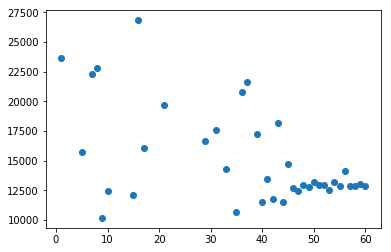

frame: 5


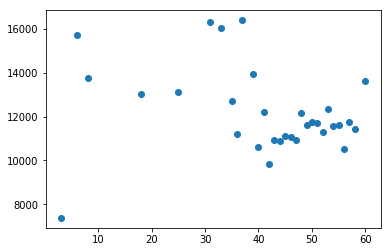

frame: 6


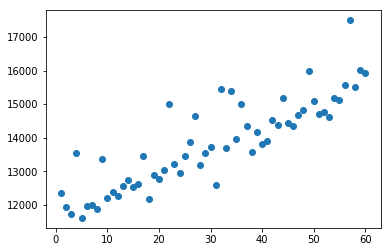

frame: 7


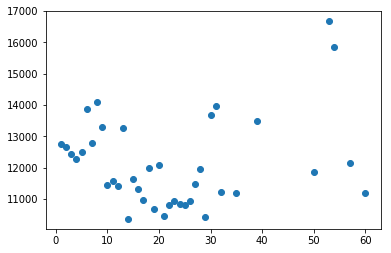

frame: 8


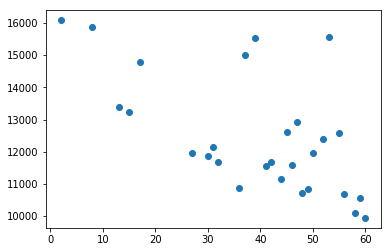

frame: 9


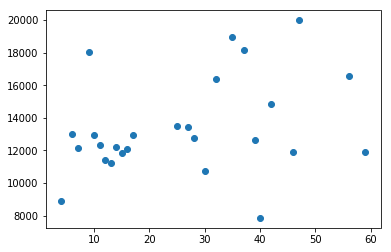

frame: 10


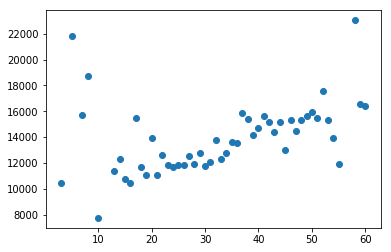

In [30]:
for i, frame in enumerate(time_per_layer):
    if i > 10:
        break
    print "frame:",i
    plt.scatter(frame[0], frame[1])
    plt.show()

In [33]:
"""
berechne durchschnittliche z-koordinate jedes stockwerks
"""
omheight={}
for om in range(1,65):
    heights=np.array([])
    for string in range(1,87):
        omkey = icetray.OMKey(string, om, 0)
        if omkey in geo:
            heights = np.append(heights, geo[omkey].position[2])
    omheight[om] = heights.mean()
#man sieht: om>60 sind icetop doms. aber die kommen in den pulsen eh nirgends vor, also egal.

In [35]:
from scipy import stats
#verwende frame 6, da dieses geile korrelation hat
frame_n=6
print stats.linregress(time_per_layer[frame_n])
print stats.linregress(map(lambda x: omheight[x], time_per_layer[frame_n][0]),time_per_layer[frame_n][1])
print trueval_arr[frame_n]

LinregressResult(slope=65.940038472171551, intercept=11819.114409174239, rvalue=0.87149296256896069, pvalue=1.3432747794152214e-19, stderr=4.8722422101177916)
LinregressResult(slope=-4.0069914572970706, intercept=13734.495384081732, rvalue=-0.87044127588445486, pvalue=1.6758690020035807e-19, stderr=0.29755709695830473)
[4585038.02761706, 1.8313486984444793, 0.5179179421978182]
